### Variational Autoencoders for non-supervised intrusion detection

We train the variational autoencoders with 'normal' traffic <br>
We test it with 'attack' traffic and obtain result <br>
<br>
PCA Analysis of the results <br>
Visualization analysis on how the MAE splits the result <br>

\


In [1]:
# Pointer to check
# https://github.com/a-agmon/anomaly_det/blob/master/AnomalyDetectorsVAE-KDD-original.ipynb
# https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

2022-03-11 00:45:06.593706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-11 00:45:06.593730: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Hyperparameters

NOISE = 0.2        # amount of noise to add to exercise
NETWORK = 'ANN'    # or ANN
THRESHOLD = 1      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.05 # threshold for deterministic

In [4]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 

In [5]:
path = './data/Zero_Day/'
path_normal = path +'Normal.csv'
path_combine = path +'Combine.csv'
path_attack = path +'Attack.csv'

traffic_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  
attack_df = pd.read_csv(path_attack)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
len(combine_labels)

78377

In [6]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
traffic_np = traffic_df.to_numpy()
print('normal shape',traffic_np.shape)
combine_np = combine_df.to_numpy()
print('combine shape', combine_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (22714, 129)
combine shape (78377, 129)
attack shape (55663, 129)


In [7]:
#drop marker column
combine_df.drop(['marker'], axis=1, inplace=True)
# standardize 
combine_df = combine_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(combine_df)

In [8]:
labels = combine_labels
ATTACK_LABEL = 1
NORMAL_LABEL = 0

norm_samples = df_scaled[labels == NORMAL_LABEL]  # normal data
attack_samples = df_scaled[labels == ATTACK_LABEL]  # attack data

norm_labels = labels[labels == NORMAL_LABEL]
attack_labels = labels[labels == ATTACK_LABEL]
print('normal size labels', norm_labels.shape)
print('attack size labels',attack_labels.shape)

normal size labels (22714,)
attack size labels (55663,)


In [9]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.9 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [10]:
X_train.shape

(20442, 128)

In [11]:
X_test.shape

(4544, 128)

In [12]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [13]:
# The reparameterization trick
from tensorflow.keras import layers
def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [14]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
intermediate_dim = 1024
#latent_dim = 512

In [15]:
# fixing shapes for CNN
X_train = X_train[...,np.newaxis]
X_test = X_test[...,np.newaxis]

In [16]:
latent_dim = 2

# encoder model
name='encoder_input'
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]),name='encoder_input')
x = layers.Conv1D(128, 3, activation="relu", strides=2, padding="same")(inputs)
# x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
#z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z        = Sampling()([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64, 128)      512         ['encoder_input[0][0]']          
                                                                                                  
 conv1d_1 (Conv1D)              (None, 32, 32)       12320       ['conv1d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 1024)         0           ['conv1d_1[0][0]']               
                                                                                            

In [21]:
#decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(32*32, activation="relu")(latent_inputs)
x = layers.Reshape((32,32))(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
#x = layers.Conv1DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              3072      
                                                                 
 reshape_1 (Reshape)         (None, 32, 32)            0         
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 64, 32)           3104      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 128, 128)         12416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_5 (Conv1DT  (None, 128, 1)           385 

In [22]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [23]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [24]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=2000,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 1)]          0         
                                                                 
 encoder (Functional)        (None, 2)                 29300     
                                                                 
 decoder (Functional)        (None, 128, 1)            18977     
                                                                 
Total params: 48,277
Trainable params: 48,277
Non-trainable params: 0
_________________________________________________________________
Train on 20442 samples
Epoch 1/2000
20442/20442 [==============================] - 4s 211us/sample - loss: 3944.0329
Epoch 2/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 3340.9305
Epoch 3/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 2395.4956
Epoch 4/2000
2

20442/20442 [==============================] - 4s 190us/sample - loss: 223.3791
Epoch 80/2000
20442/20442 [==============================] - 4s 194us/sample - loss: 222.3400
Epoch 81/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 221.4573
Epoch 82/2000
20442/20442 [==============================] - 4s 189us/sample - loss: 220.4276
Epoch 83/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 219.5178
Epoch 84/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 218.5035
Epoch 85/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 217.6369
Epoch 86/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 216.5336
Epoch 87/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 215.9086
Epoch 88/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 214.9445
Epoch 89/2000
20442/20442 [==============================] - 4s 190us/samp

20442/20442 [==============================] - 4s 190us/sample - loss: 177.9929
Epoch 166/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 177.6827
Epoch 167/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 177.3972
Epoch 168/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 177.2612
Epoch 169/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 176.8017
Epoch 170/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 176.4612
Epoch 171/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 176.1316
Epoch 172/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 175.9313
Epoch 173/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 175.5751
Epoch 174/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 175.2695
Epoch 175/2000
20442/20442 [==============================] - 4s 

20442/20442 [==============================] - 4s 190us/sample - loss: 160.2695
Epoch 252/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 160.0249
Epoch 253/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 160.0135
Epoch 254/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 159.6065
Epoch 255/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 159.5279
Epoch 256/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 159.3601
Epoch 257/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 159.1279
Epoch 258/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 159.3723
Epoch 259/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 159.6765
Epoch 260/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 159.0709
Epoch 261/2000
20442/20442 [==============================] - 4s 

20442/20442 [==============================] - 4s 192us/sample - loss: 149.9379
Epoch 338/2000
20442/20442 [==============================] - 4s 189us/sample - loss: 150.0159
Epoch 339/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 150.3735
Epoch 340/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 149.7355
Epoch 341/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 149.8786
Epoch 342/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 149.8246
Epoch 343/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 149.4049
Epoch 344/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 149.4552
Epoch 345/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 149.3863
Epoch 346/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 149.4068
Epoch 347/2000
20442/20442 [==============================] - 4s 

20442/20442 [==============================] - 4s 191us/sample - loss: 143.1141
Epoch 424/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 143.3801
Epoch 425/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 142.8952
Epoch 426/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 142.9356
Epoch 427/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 143.2843
Epoch 428/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 142.7499
Epoch 429/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 142.8973
Epoch 430/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 142.7971
Epoch 431/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 142.6840
Epoch 432/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 143.0928
Epoch 433/2000
20442/20442 [==============================] - 4s 

20442/20442 [==============================] - 4s 191us/sample - loss: 138.0374
Epoch 510/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 138.0227
Epoch 511/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 137.9320
Epoch 512/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 138.4614
Epoch 513/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 137.9573
Epoch 514/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 138.0183
Epoch 515/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 137.9168
Epoch 516/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 137.9436
Epoch 517/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 137.6759
Epoch 518/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 138.0649
Epoch 519/2000
20442/20442 [==============================] - 4s 

20442/20442 [==============================] - 4s 192us/sample - loss: 133.8522
Epoch 596/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 133.2891
Epoch 597/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 133.6865
Epoch 598/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 133.8011
Epoch 599/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 133.5720
Epoch 600/2000
20442/20442 [==============================] - 4s 189us/sample - loss: 133.6089
Epoch 601/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 133.3388
Epoch 602/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 133.2549
Epoch 603/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 132.9335
Epoch 604/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 133.4047
Epoch 605/2000
20442/20442 [==============================] - 4s 

20442/20442 [==============================] - 4s 192us/sample - loss: 130.0306
Epoch 682/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 130.2268
Epoch 683/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 130.4964
Epoch 684/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 130.4443
Epoch 685/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 129.9966
Epoch 686/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 130.0026
Epoch 687/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 129.7826
Epoch 688/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 130.0998
Epoch 689/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 129.8706
Epoch 690/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 129.7282
Epoch 691/2000
20442/20442 [==============================] - 4s 

20442/20442 [==============================] - 4s 192us/sample - loss: 127.2863
Epoch 768/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 127.6725
Epoch 769/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 127.3153
Epoch 770/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 127.7159
Epoch 771/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 127.7357
Epoch 772/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 127.5848
Epoch 773/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 127.3594
Epoch 774/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 127.7311
Epoch 775/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 127.4998
Epoch 776/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 127.4041
Epoch 777/2000
20442/20442 [==============================] - 4s 

20442/20442 [==============================] - 4s 191us/sample - loss: 125.2787
Epoch 854/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 125.2256
Epoch 855/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 125.7563
Epoch 856/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 125.4027
Epoch 857/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 125.0927
Epoch 858/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 125.0628
Epoch 859/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 125.5621
Epoch 860/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 125.4938
Epoch 861/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 125.0562
Epoch 862/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 125.1406
Epoch 863/2000
20442/20442 [==============================] - 4s 

20442/20442 [==============================] - 4s 191us/sample - loss: 123.4266
Epoch 940/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 123.6543
Epoch 941/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 123.8379
Epoch 942/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 123.7142
Epoch 943/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 123.7673
Epoch 944/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 123.9734
Epoch 945/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 123.2673
Epoch 946/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 123.2418
Epoch 947/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 123.1109
Epoch 948/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 123.4347
Epoch 949/2000
20442/20442 [==============================] - 4s 

20442/20442 [==============================] - 4s 190us/sample - loss: 122.1872
Epoch 1026/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 122.1919
Epoch 1027/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 121.7203
Epoch 1028/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 121.5988
Epoch 1029/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 121.6546
Epoch 1030/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 122.3323
Epoch 1031/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 121.6755
Epoch 1032/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 121.6665
Epoch 1033/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 121.7931
Epoch 1034/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 121.3978
Epoch 1035/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 193us/sample - loss: 120.1386
Epoch 1111/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 120.9733
Epoch 1112/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 120.3358
Epoch 1113/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 120.3519
Epoch 1114/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 120.2267
Epoch 1115/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 120.4085
Epoch 1116/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 120.1353
Epoch 1117/2000
20442/20442 [==============================] - 4s 194us/sample - loss: 120.7519
Epoch 1118/2000
20442/20442 [==============================] - 4s 194us/sample - loss: 120.1756
Epoch 1119/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 120.8259
Epoch 1120/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 193us/sample - loss: 118.9585
Epoch 1196/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 118.9848
Epoch 1197/2000
20442/20442 [==============================] - 4s 195us/sample - loss: 118.9060
Epoch 1198/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 118.8379
Epoch 1199/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 119.5311
Epoch 1200/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 119.1047
Epoch 1201/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 119.2563
Epoch 1202/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 118.7690
Epoch 1203/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 120.1269
Epoch 1204/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 118.9537
Epoch 1205/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 190us/sample - loss: 117.6674
Epoch 1281/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 117.9564
Epoch 1282/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 117.8427
Epoch 1283/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 117.6979
Epoch 1284/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 117.5971
Epoch 1285/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 118.0988
Epoch 1286/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 117.4392
Epoch 1287/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 117.5561
Epoch 1288/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 117.8365
Epoch 1289/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 117.3334
Epoch 1290/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 192us/sample - loss: 116.8594
Epoch 1366/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 116.5798
Epoch 1367/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 116.8817
Epoch 1368/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 116.7456
Epoch 1369/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 116.8390
Epoch 1370/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 116.9330
Epoch 1371/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 116.7796
Epoch 1372/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 116.7693
Epoch 1373/2000
20442/20442 [==============================] - 4s 189us/sample - loss: 117.1452
Epoch 1374/2000
20442/20442 [==============================] - 4s 194us/sample - loss: 116.5112
Epoch 1375/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 190us/sample - loss: 115.7826
Epoch 1451/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 115.9285
Epoch 1452/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 116.6911
Epoch 1453/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 115.9832
Epoch 1454/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 116.2110
Epoch 1455/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 116.3528
Epoch 1456/2000
20442/20442 [==============================] - 4s 189us/sample - loss: 116.1299
Epoch 1457/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 115.6607
Epoch 1458/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 115.7069
Epoch 1459/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 116.1042
Epoch 1460/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 190us/sample - loss: 114.3292
Epoch 1536/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 114.7728
Epoch 1537/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 115.2301
Epoch 1538/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 115.0025
Epoch 1539/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 114.5907
Epoch 1540/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 115.0297
Epoch 1541/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 114.5709
Epoch 1542/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 114.8989
Epoch 1543/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 114.5435
Epoch 1544/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 114.5108
Epoch 1545/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 192us/sample - loss: 113.8755
Epoch 1621/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 113.8194
Epoch 1622/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 114.8793
Epoch 1623/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 114.0889
Epoch 1624/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 114.0590
Epoch 1625/2000
20442/20442 [==============================] - 4s 195us/sample - loss: 115.4159
Epoch 1626/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 114.3319
Epoch 1627/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 114.4784
Epoch 1628/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 114.0376
Epoch 1629/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 113.8350
Epoch 1630/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 193us/sample - loss: 113.2961
Epoch 1706/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 112.8603
Epoch 1707/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 113.2286
Epoch 1708/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 113.1740
Epoch 1709/2000
20442/20442 [==============================] - 4s 189us/sample - loss: 112.6625
Epoch 1710/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 113.4408
Epoch 1711/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 113.3787
Epoch 1712/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 113.0943
Epoch 1713/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 113.0868
Epoch 1714/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 113.4151
Epoch 1715/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 192us/sample - loss: 112.2337
Epoch 1791/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 112.4002
Epoch 1792/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 112.2194
Epoch 1793/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 112.5641
Epoch 1794/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 112.2707
Epoch 1795/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 112.6187
Epoch 1796/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 112.7130
Epoch 1797/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 113.0988
Epoch 1798/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 112.4130
Epoch 1799/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 112.4254
Epoch 1800/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 192us/sample - loss: 111.8077
Epoch 1876/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 111.2154
Epoch 1877/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 111.9380
Epoch 1878/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 111.5167
Epoch 1879/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 111.6256
Epoch 1880/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 111.5820
Epoch 1881/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 111.5069
Epoch 1882/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 111.3368
Epoch 1883/2000
20442/20442 [==============================] - 4s 190us/sample - loss: 111.4287
Epoch 1884/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 111.7200
Epoch 1885/2000
20442/20442 [===========================

20442/20442 [==============================] - 4s 194us/sample - loss: 110.9614
Epoch 1961/2000
20442/20442 [==============================] - 4s 194us/sample - loss: 111.4243
Epoch 1962/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 110.9821
Epoch 1963/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 110.9514
Epoch 1964/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 110.8708
Epoch 1965/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 110.7851
Epoch 1966/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 110.4583
Epoch 1967/2000
20442/20442 [==============================] - 4s 193us/sample - loss: 111.1790
Epoch 1968/2000
20442/20442 [==============================] - 4s 192us/sample - loss: 111.0024
Epoch 1969/2000
20442/20442 [==============================] - 4s 191us/sample - loss: 112.0297
Epoch 1970/2000
20442/20442 [===========================

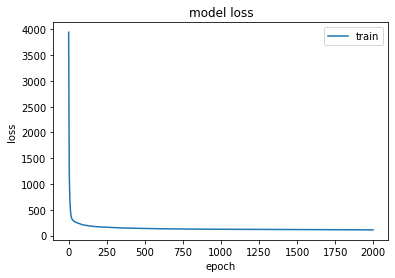

In [25]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [26]:
X_train_pred = vae_model.predict(X_train)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [27]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)
error_thresh = np.quantile(mae_vector, 0.95)
print(error_thresh)

Avg error 0.023640075194861845
median error 0.019126838184286628
99Q: 0.09570885101410904
setting threshold on 0.09570885101410904 
0.049639751252750615


In [28]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total anomalies',len(anomalies))
print(np.count_nonzero(anomalies))

print('total y_test',len(y_test))
print(np.count_nonzero(y_test))

total anomalies 4544
315
total y_test 4544
2272


In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.51      0.95      0.66      2272
         1.0       0.65      0.09      0.16      2272

    accuracy                           0.52      4544
   macro avg       0.58      0.52      0.41      4544
weighted avg       0.58      0.52      0.41      4544



In [30]:
X_pred.shape

(4544, 128, 1)

In [31]:
X_encoded = encoder.predict(X_test)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [32]:
X_encoded

array([[ 2.5742912 ,  0.03711062],
       [ 2.5622854 ,  0.02634763],
       [ 2.5371747 ,  0.02927326],
       ...,
       [-1.7168254 ,  2.3370051 ],
       [-1.6950755 ,  2.3584611 ],
       [-1.6942806 ,  2.398264  ]], dtype=float32)

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

In [34]:
mae_vector = np.squeeze(mae_vector)
anomalies = np.squeeze(anomalies)

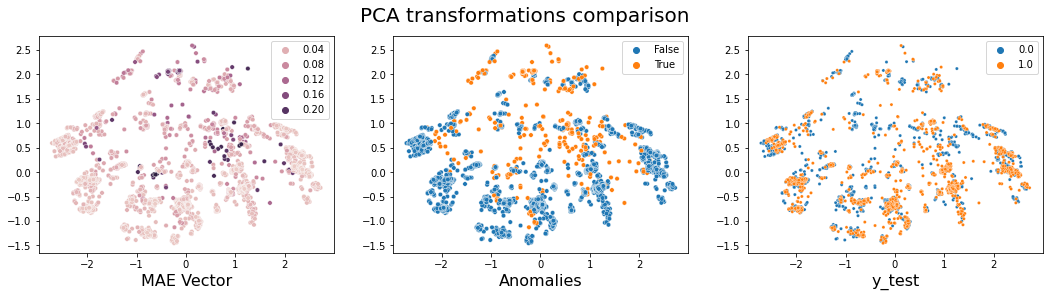

In [35]:
# comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
plt.show()

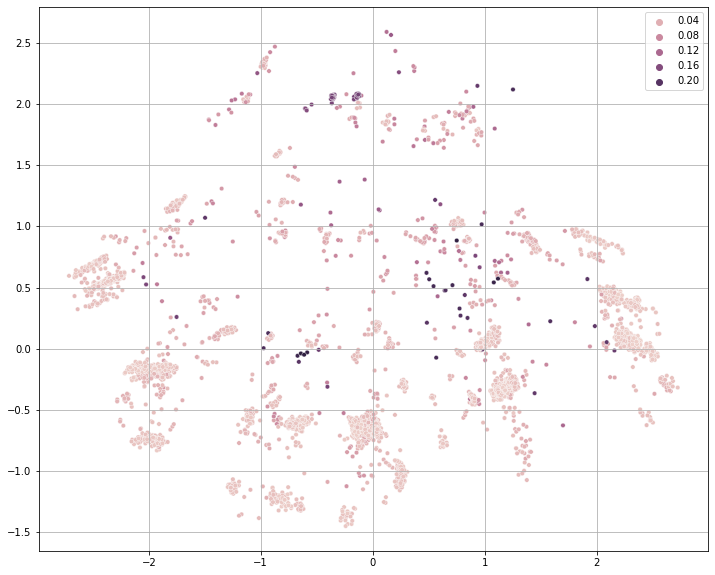

In [36]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

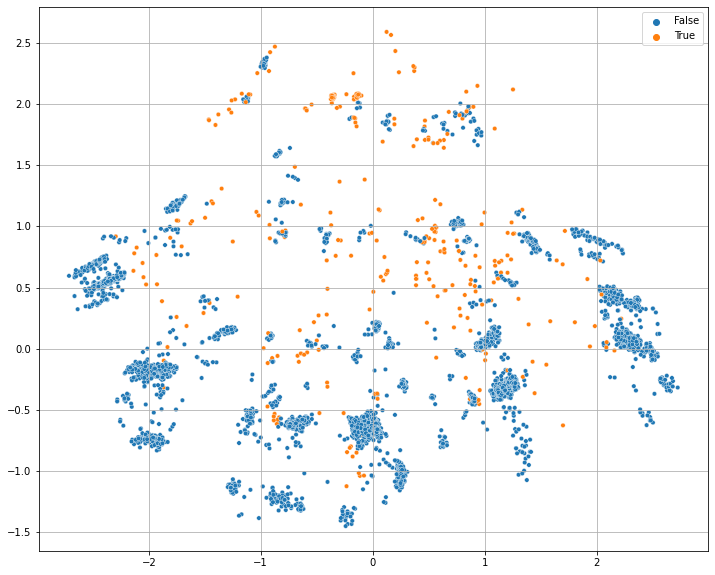

In [37]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

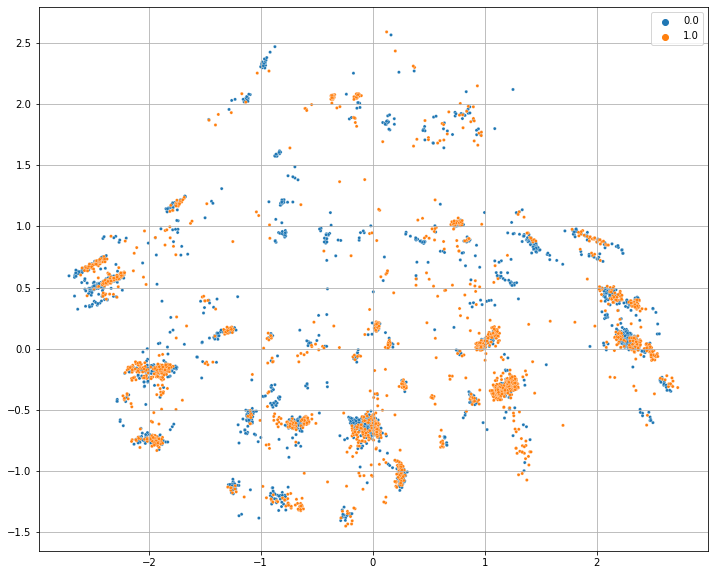

In [38]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [ ]:
X_pred.shape

In [ ]:
# figure
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
print(error_thresh)
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()